<a href="https://colab.research.google.com/github/Tyler-oc/Neural_Net_Facial_Recognition/blob/main/ML_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [12]:
df_train = pd.read_csv('Data_Train.csv')
df_dev = pd.read_csv('Data_Development.csv')
df_test = pd.read_csv('Data_Test.csv')
print(df_train.dtypes)
df_train.head(1)

emotion     int64
pixels     object
dtype: object


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...


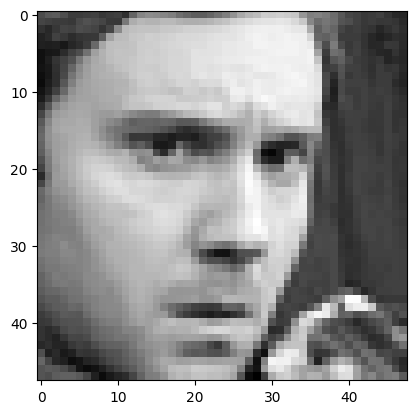

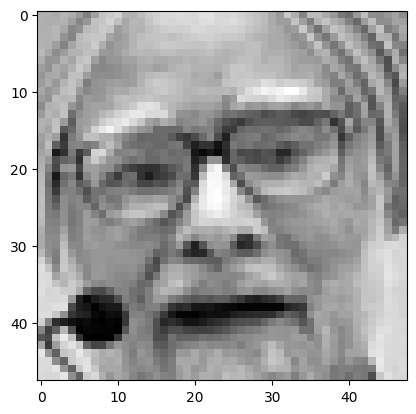

<tf.Tensor: shape=(48, 48, 1), dtype=float32, numpy=
array([[[ 0.5881538 ],
        [ 0.5636766 ],
        [ 0.49024504],
        ...,
        [ 0.04965561],
        [ 0.3189047 ],
        [-0.1706391 ]],

       [[ 0.5881538 ],
        [ 0.5391994 ],
        [ 0.5391994 ],
        ...,
        [-0.12168472],
        [ 0.34338188],
        [ 0.24547313]],

       [[ 0.5881538 ],
        [ 0.5881538 ],
        [ 0.71053976],
        ...,
        [-0.43988818],
        [-0.09720753],
        [ 0.46576783]],

       ...,

       [[ 1.4938098 ],
        [ 1.4938098 ],
        [-0.14616191],
        ...,
        [ 1.4203782 ],
        [ 1.4203782 ],
        [ 1.4448555 ]],

       [[ 1.4938098 ],
        [ 1.4693327 ],
        [ 1.6896274 ],
        ...,
        [ 1.4448555 ],
        [ 1.3469467 ],
        [ 1.4693327 ]],

       [[ 1.4448555 ],
        [ 1.3959011 ],
        [ 1.4203782 ],
        ...,
        [ 1.6161958 ],
        [ 1.3714238 ],
        [ 1.3959011 ]]], dtype=float32)>

In [13]:
def visualize(pixels):
    pixels = np.array(pixels.split(), dtype=np.uint8)
    pixels = pixels.reshape((48, 48))
    image = np.expand_dims(pixels, axis=-1)
    image = tf.image.per_image_standardization(image)
    plt.imshow(np.squeeze(image), cmap='gray', interpolation='nearest')
    plt.show()
    return image

first_two_images_train = df_train.iloc[:2]
visualize(first_two_images_train['pixels'][0])
visualize(first_two_images_train['pixels'][1])

In [14]:
#part b, count number of emotions in each dataset

emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

print(df_train['emotion'].map(emotion_map).value_counts())
print(df_dev['emotion'].map(emotion_map).value_counts())
print(df_test['emotion'].map(emotion_map).value_counts())


emotion
Happy       7215
Neutral     4965
Sad         4830
Fear        4097
Angry       3995
Surprise    3171
Disgust      436
Name: count, dtype: int64
emotion
Happy       895
Sad         653
Neutral     607
Fear        496
Angry       467
Surprise    415
Disgust      56
Name: count, dtype: int64
emotion
Happy       879
Neutral     626
Sad         594
Fear        528
Angry       491
Surprise    416
Disgust      55
Name: count, dtype: int64


In [15]:
class NeuralNet():
    def __init__(self, input_size, hidden_layers, hidden_sizes, output_size, alpha, beta1, beta2, dropout_rate=0.5):
        self.input_size = input_size
        self.hidden_layers = hidden_layers # corrected variable name
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.dropout_rate = dropout_rate

        self.weights = []
        self.biases = []
        self.weight_first_moment = []
        self.weight_second_moment = []
        self.bias_first_moment = []
        self.bias_second_moment = []
        self.timestamp = 0

        for i in range(len(self.hidden_sizes)):
            if i == 0:
                self.weights.append(np.random.randn(self.input_size, self.hidden_sizes[i]))
            else:
                self.weights.append(np.random.randn(self.hidden_sizes[i-1], self.hidden_sizes[i]))
            self.biases.append(np.zeros((1, self.hidden_sizes[i])))
            self.weight_first_moment.append(np.zeros((self.weights[-1].shape)))
            self.weight_second_moment.append(np.zeros((self.weights[-1].shape)))
            self.bias_first_moment.append(np.zeros((self.biases[-1].shape)))
            self.bias_second_moment.append(np.zeros((self.biases[-1].shape)))


        self.weights.append(np.random.randn(self.hidden_sizes[-1], self.output_size))
        self.biases.append(np.random.randn(1, self.output_size))
        self.weight_first_moment.append(np.zeros((self.weights[-1].shape)))
        self.weight_second_moment.append(np.zeros((self.weights[-1].shape)))
        self.bias_first_moment.append(np.zeros((self.biases[-1].shape)))
        self.bias_second_moment.append(np.zeros((self.biases[-1].shape)))

    def softmax(self, x):
      e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
      return e_x / e_x.sum(axis=1, keepdims=True)

    def dsoftmax(self, x):
        return self.softmax(x) * (1 - self.softmax(x))

    def reLU(self, x):
        return np.maximum(0, x)

    def dreLU(self, x):
        return np.where(x > 0, 1, 0)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def dsigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))


    def forward(self, input_vector, training=True):
        I = input_vector
        activations = [I]
        for idx, W in enumerate(self.weights):
            I = np.dot(I, W) + self.biases[idx]
            if idx == len(self.weights) - 1:
                I = self.softmax(I)
            else:
              I = self.reLU(I)
              if training and self.dropout_rate > 0:
                dropout_mask = (np.random.rand(*I.shape) > self.dropout_rate) / (1 - self.dropout_rate)
                I *= dropout_mask
            activations.append(I)

        return activations

    def backprop(self, activations, target_vector):
      self.timestamp += 1
      error = activations[-1] - target_vector
      deltas = [error]

      for layer in np.arange(len(activations) - 2, 0, -1):
        delta = np.dot(deltas[-1], self.weights[layer].T) * self.dreLU(activations[layer])
        deltas.append(delta)

      deltas.reverse()



      for layer in np.arange(len(self.weights)):
        weight_gradient = np.dot(activations[layer].T, deltas[layer])
        bias_gradient = np.sum(deltas[layer], axis=0, keepdims=True)

        self.weight_first_moment[layer] = self.beta1 * self.weight_first_moment[layer] + (1 - self.beta1) * weight_gradient
        self.weight_second_moment[layer] = self.beta2 * self.weight_second_moment[layer] + (1 - self.beta2) * weight_gradient**2

        self.bias_first_moment[layer] = self.beta1 * self.bias_first_moment[layer] + (1 - self.beta1) * bias_gradient
        self.bias_second_moment[layer] = self.beta2 * self.bias_second_moment[layer] + (1 - self.beta2) * bias_gradient**2

        #correction (m / (1 - beta ^ t))
        corrected_weight_first_moment = self.weight_first_moment[layer] / (1 - self.beta1**self.timestamp)
        corrected_weight_second_moment = self.weight_second_moment[layer] / (1 - self.beta2**self.timestamp)

        corrected_bias_first_moment = self.bias_first_moment[layer] / (1 - self.beta1**self.timestamp)
        corrected_bias_second_moment = self.bias_second_moment[layer] / (1 - self.beta2**self.timestamp)

        self.weights[layer] -= self.alpha * corrected_weight_first_moment / (np.sqrt(corrected_weight_second_moment) + 1e-8)
        self.biases[layer] -= self.alpha * corrected_bias_first_moment / (np.sqrt(corrected_bias_second_moment) + 1e-8)


    def predict(self, input_vector):
        activations = self.forward(input_vector, training=False)
        return activations[-1]

    def predict_emotion(self, input_vector):
        activations = self.forward(input_vector, training=False)
        return np.argmax(activations[-1])

    def batch_backprop(self, batch_data, batch_size):
        for index, row in batch_data.iterrows():
            pixels = row['pixels']
            pixels = np.array(pixels.split(), dtype=np.uint8).reshape(1, -1)
            emotion = row['emotion']
            target_vector = np.zeros(7)
            target_vector[emotion] = 1
            target_vector = target_vector.reshape(1, -1)

            activations = self.forward(pixels)
            loss = self.cross_entropy_loss(target_vector, activations[-1])
            self.backprop(activations, target_vector)
        return loss # Return the loss after processing the batch


    def cross_entropy_loss(self, target_vector, out_vector):
      epsilon = 1e-15
      out_vector = np.clip(out_vector, epsilon, 1 - epsilon)
      return -np.sum(target_vector * np.log(out_vector)) / target_vector.shape[0]


In [16]:
neural_net = NeuralNet(48*48, 2, [16, 16], 7, 0.002, .9, .999, .5)
def batch_train(neural_net, training_data, batch_size, epochs):
    for epoch in range(epochs):
      total_epoch_loss = 0
      num_batches = 0
      for batch in range(0, len(training_data), batch_size):
        batch_data = training_data.iloc[batch:batch+batch_size]
        batch_loss = neural_net.batch_backprop(batch_data, batch_size)
        total_epoch_loss += batch_loss
        num_batches += 1
      average_epoch_loss = total_epoch_loss / num_batches
      print(f'Epoch {epoch + 1} complete, Average Loss: {average_epoch_loss}')

In [17]:
def validate(neural_net, validation_data):
    correct_predictions = 0
    total_predictions = 0

    for index, row in validation_data.iterrows():
        pixels = row['pixels']
        pixels = np.array(pixels.split(), dtype=np.uint8).reshape(1, -1)
        emotion = row['emotion']
        target_vector = np.zeros(7)
        target_vector[emotion] = 1
        target_vector.reshape(1, -1)

        predicted_emotion = neural_net.predict_emotion(pixels)
        if predicted_emotion == emotion:
            correct_predictions += 1
        total_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

In [18]:
batch_train(neural_net, df_train, 32, 3)

Epoch 1 complete, Average Loss: 1.9035028711973356
Epoch 2 complete, Average Loss: 1.8159370958570584
Epoch 3 complete, Average Loss: 1.8159490495360346


In [19]:
accuracy = validate(neural_net, df_dev)
print(f'Validation Accuracy: {accuracy}')

Validation Accuracy: 0.24937308442463083
